#### This program is designed to train a model of an apple and banana for prediction and then predict the overall freshness of the apple or banana. 
#### It does this buy first uploading the data set to the program. Then using a CNN Sequential 4-layer model, it trains the dataset. Once trained the dataset can be used to predict confidence ratings in a banana or an apple. 
#### After this model is trained the program then uses histogram matching techniques to split out the red blue and green properties of the image. Once these features are extracted the program calculates the cumulative distribution function to get the aera under each histogram curve. 
#### Once this area is found, testing and observing of the histogram outputs lets the user know what the thresholding should be on the program to predict ripeness of the fruit. 


In [2]:
# Setting up libraries
import numpy as np
import pandas as pd
import argparse
import glob
import cv2
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from keras import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
#from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
#from sklearn.model_selection import train_test_split
#from skimage import io
import os
import tensorflow as tf
import zipfile
from collections import defaultdict
#from scipy import imread, imresize
from keras import regularizers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

#Push physical devices list for GPU
physical_devices = tf.config.list_physical_devices('GPU')
try:
# Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass



#### This is the function declaration section of the program. These functions have a variety of uses for debugging code, to plotting realized data, and general functionally of the program. 

In [ ]:
# Funtction to load images form file path for training/testing
def load_images_form_file(path):
    img_data = []
    labels = []
    idx_to_label = []
    i = -1
    for fruit in os.listdir(path):
        fruit_path = os.path.join(path,fruit)
        labels.append(fruit)
        i = i+1
        for img in os.listdir(fruit_path):
            img_path = os.path.join(fruit_path,img)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (64, 64))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            img_data.append(image)
            idx_to_label.append(i)
    return np.array(img_data),np.array(idx_to_label),labels

# Funtction to load images form file path for querys
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.resize(img, (64, 64))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            #img = img.astype("float32") / 255
            img = np.expand_dims(img, axis=0)
            images.append(img)
            #images
    return images

# Funtction to converge file paths to dict
def conv_image_files(image_path,conversion=cv2.COLOR_BGR2HSV): #cv2.COLOR_BGR2RGB  cv2.COLOR_BGR2HSV
    image_list = [(os.path.basename(f),cv2.imread(f,conversion)) for f in image_path]
    image_dict = {file:image for (file,image) in image_list}
    return image_dict

# Funtction to plot histograms
def plotting_hist(images,query):    
    plt.imshow(cv2.cvtColor(images[query], cv2.COLOR_BGR2RGB))
    plt.title(query)
    plt.show()
    color = ('r','g','b')
    
    for i,col in enumerate(color):
        hist = cv2.calcHist([images[query]],[i],None,[300],[5,252])
        plt.plot(hist,color = col)
        plt.xlim([0,256])
        plt.ylim([0,40])
        plt.title(query)
    plt.show()
    return

# Funtction to plot generate histograms and keep in R G B
def generate_histogram_rgb(image_dict, number_bins=8, l_pix = 10,h_pix = 250):
    histogram_dict = dict()
    overall_hist = []
    for filename in image_dict:
        image = image_dict[filename]        
        hist0 = cv2.calcHist([image], [0], None, [number_bins], [l_pix ,h_pix ])
        hist1 = cv2.calcHist([image], [1], None, [number_bins], [l_pix ,h_pix])
        hist2 = cv2.calcHist([image], [2], None, [number_bins], [l_pix ,h_pix])
        overall_hist.append(hist0)
        overall_hist.append(hist1)
        overall_hist.append(hist2)
        
        histogram_dict[filename] =[hist0,hist1,hist2]    
    return histogram_dict

# Funtction to calculate cumulative distribution function
def calculate_cdf(histogram):

    # Get the cumulative sum of the elements
    cdf = histogram.cumsum()
 
    # Normalize the cdf
    normalized_cdf = cdf / float(cdf.max())
 
    return normalized_cdf

# Funtction to calculate ripeness of fruit based on histogram R G B
def ripeness_check(query):
    
    red = calculate_cdf(query[0])
    green = calculate_cdf(query[1])
    blue = calculate_cdf(query[2])
    
    avg_red = sum(red)/len(red)    
    avg_green = sum(green)/len(green)
    avg_blue = sum(blue)/len(blue)
    #print("avg. scores")      #DEBUG
    #print(avg_red)            #DEBUG
    #print(avg_green)          #DEBUG
    #print(avg_blue)           #DEBUG
    
    tot_area=avg_red+avg_green+avg_blue
    rperc=avg_red/tot_area
    gperc=avg_green/tot_area
    bperc=avg_blue/tot_area
    #print("perct. scores")   #DEBUG
    #print(rperc)             #DEBUG
    #print(gperc)             #DEBUG
    #print(bperc)             #DEBUG
    #Adjust the limits for your fruit
    glimit=0.4
    ylimit=0.3
    blimit=0.4

    if avg_blue >blimit:                #avg_green >glimit:   #DEBUG
        #print ("High Ripeness")
        return str("Low Ripeness")
    elif avg_green>glimit:              #avg_red>ylimit:      #DEBUG
        #print ("Low Ripeness")
        return str("High Ripeness")
    else:
        #print ("Medium Ripeness")
        return str("Medium Ripeness")

# Funtction to load single image 
def load_image(filename):
    image = cv2.imread(test_path)
    image = cv2.resize(image, (64, 64))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = image.astype("float32") / 255
    test_img = np.expand_dims(image, axis=0)
    #print (test_img.shape)
    return test_img

# Funtction to summarize_diagnostics of trained model
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.xlabel('Training Epochs')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.tight_layout(pad=2)
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.xlabel('Training Epochs')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        plt.ylim(0.75, 1)
    plt.show()

# Funtction to plot accuracy of trained model 
def plot_histoy(history):
    plt.plot(history.history["val_accuracy"],color="r",label="val_accuracy")
    plt.title("Accuracy Graph")
    plt.xlabel("number of epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.grid()
    plt.show()
    return

#### We are now entering the training model of the program. As stated in the header we are using a CNN model to train and test the data set. 
#### Note: if you want to train more data, this model is scalable but please review the comments before attempting. 

In [3]:
# Set up paths to train/test 
path_to_train = 'PATH'
path_to_test = 'PATH'

#Split and shape for testing
X_train,y_train,label_data = load_images_form_file(path_to_train)
X_test,y_test,label_data_garbage = load_images_form_file(path_to_test)
num_of_classes = 2
Y_train = np_utils.to_categorical(y_train, num_of_classes)
Y_test = np_utils.to_categorical(y_test, num_of_classes)
#print(X_train.shape)  #DEBUG
#print(y_train.shape)  #DEBUG
#print(label_data)     #DEBUG

In [4]:
# Train model
model = Sequential()
# 1st layer                  
model.add(Conv2D(16, (3, 3), input_shape=(64,64,3))) # Note input shape 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# 2nd layer
model.add(Conv2D(32,(3,3 )))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# 3nd layer
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# Fully connected layer
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.7))           # Note dropout if overfitted 
model.add(Dense(2))
# Activation layer
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 16)        0

In [5]:
# Set compile parameters 
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
# Train generator 
gen = ImageDataGenerator(width_shift_range=.2, height_shift_range=.2, zoom_range = 0.1,horizontal_flip = 'True')
test_gen = ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=32)
test_generator = test_gen.flow(X_test, Y_test, batch_size=32)

In [6]:
# Fit model 
history=model.fit(train_generator, epochs=3, validation_data=test_generator)

Epoch 1/3
31/31 [==============================] - 2s 57ms/step - loss: 0.0349 - accuracy: 0.9847 - val_loss: 0.1605 - val_accuracy: 0.9608
Epoch 2/3
31/31 [==============================] - 2s 54ms/step - loss: 0.0017 - accuracy: 0.9990 - val_loss: 0.0996 - val_accuracy: 1.0000
Epoch 3/3
31/31 [==============================] - 2s 56ms/step - loss: 2.8181e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000


##### Once the model is trained we can then use various function calls to inspect the output. These are powerful functions to use to analyze the data on how well the model works for prediction.

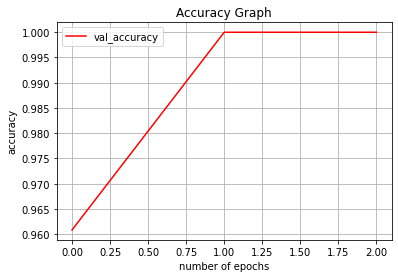

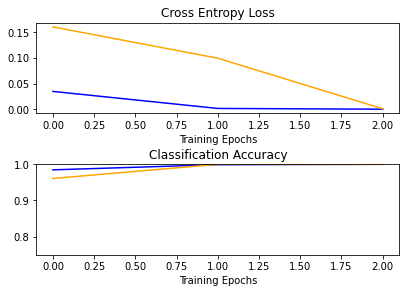

In [7]:
# Print your convergence and accuracy graphs
plot_histoy(history)
summarize_diagnostics([history])

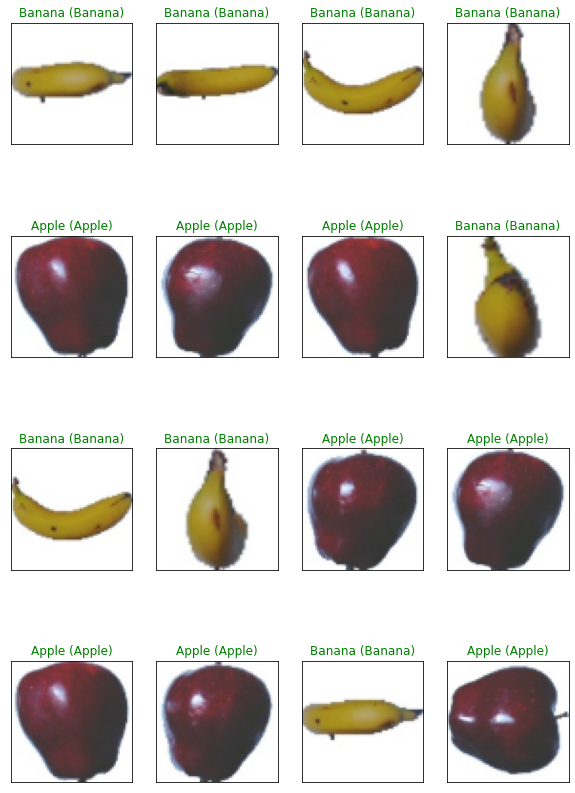

In [8]:
# plot a random sample of test images, their predicted labels, and ground truth
y_pred = model.predict(X_test)
fig = plt.figure(figsize=(10, 15))
for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4,4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(Y_test[idx])
    ax.set_title("{} ({})".format(label_data[pred_idx], label_data[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [9]:
#Save the model 
model.save("model_final.h5")
#Load the model
test_model = load_model("model_final.h5")
test_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

#### Once we have saved the model we then enter the histogram manipulation and data analysis portion of our program. 

In [10]:
#Test some images to see if the model loaded correctly 
#'/home/students/clarke.dunn/CV_Project_2nd/working/targetsrotten'
#fresh_appleripe.png  fresh_bananaripe.png  full_applefull.png full_bananafull.png half_applehalf.png half_bananahalf.png
test_path ='PATH'
test_path2 ='PATH'

test_img = load_image(test_path)
test_img2 = load_image(test_path2)

#Get shape to confirm
prediction = test_model.predict_classes(test_img)
prediction2 = test_model.predict_classes(test_img2)
print(prediction)
print(prediction2)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[1]
[1]


In [11]:
testing = []
full_test_path = 'PATH'
testing = load_images_from_folder(full_test_path)
prediction = test_model.predict(testing[0])

#See what your predictions look like 
print(prediction)
print(prediction[0][1])
print(prediction[0][0])    
print(len(testing))

[[0.06931429 0.9306857 ]]
0.9306857
0.06931429
6


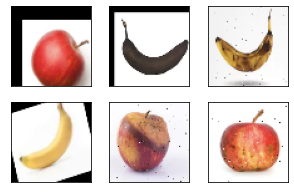

In [12]:
#View all the loaded testing data
fig = plt.figure(figsize=(5,5))
for i in range(len(testing)):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(testing[i]))

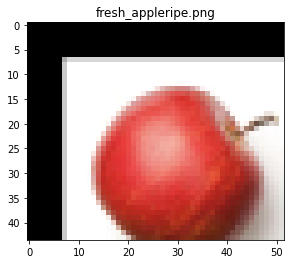

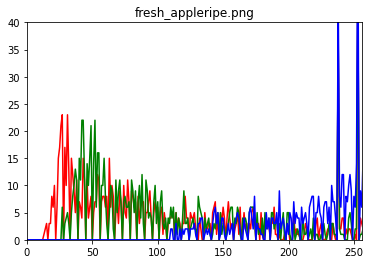

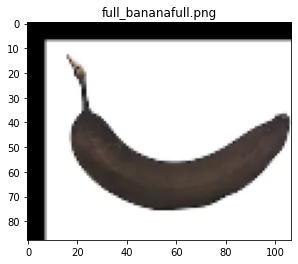

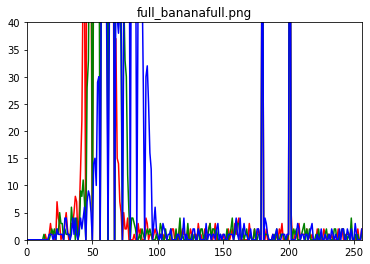

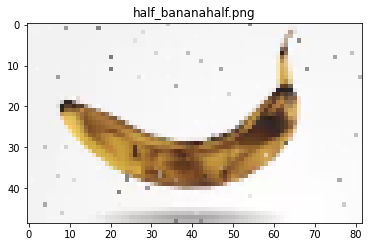

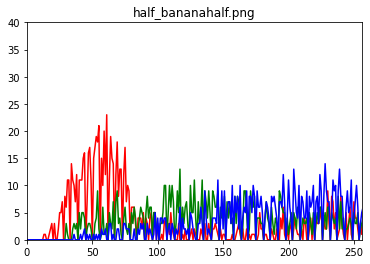

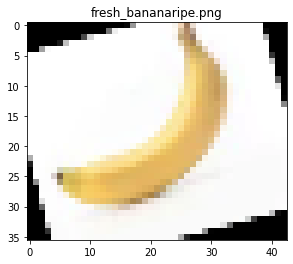

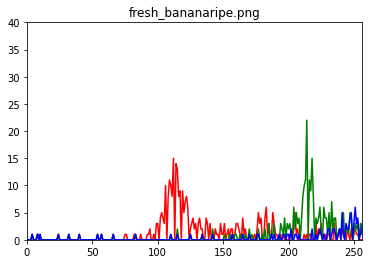

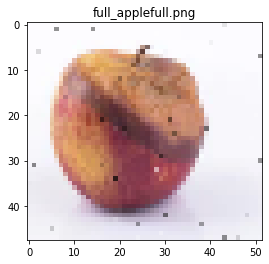

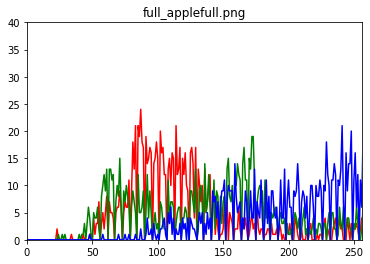

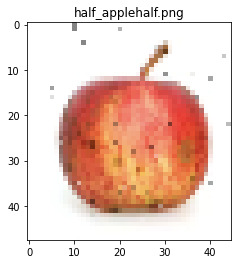

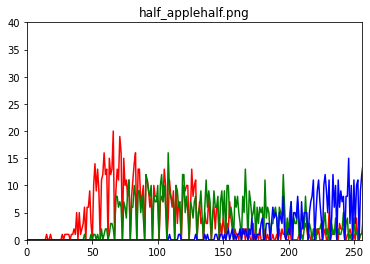

In [13]:
#Set data set to look into the histograms to look into how you should score your ripeness function

ripe_check = []
ripe_test_path = 'PATH'
image_files = glob.glob(ripe_test_path + '/**/*.png', recursive=True)
ripe_check = conv_image_files(image_files)
ripe_check_hist = generate_histogram_rgb(ripe_check)
vocab = list(ripe_check_hist.keys())

#DEBUG
##fresh_appleripe.png  fresh_bananaripe.png  full_applefull.png full_bananafull.png half_applehalf.png half_bananahalf.png
#print(vocab[0])
for i in range(len(vocab)):
    plotting_hist(ripe_check, vocab[i])

In [14]:
predict_run = []
for i in range(len(testing)):
    predict_run.append(testing[i])
    predict_run.append(test_model.predict(testing[i]))


Text(0.5, 1.0, 'With conf[0.06931429 0.9306857 ]High Ripeness')

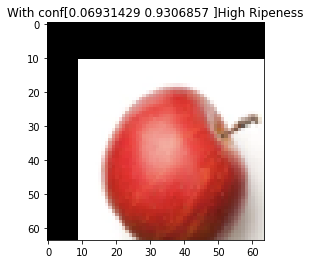

In [15]:
plt.figure()
plt.imshow(predict_run[0][0])
plt.title("With conf"+str(predict_run[1][0])+str(ripeness_check(ripe_check_hist['fresh_appleripe.png'])))

#### This is the final output of our program. It predicts with the trained model and then guesses the apple and bananas ripeness. You can see that it has 50% correct predictions, but the other predictions are only one step away from their correct output.

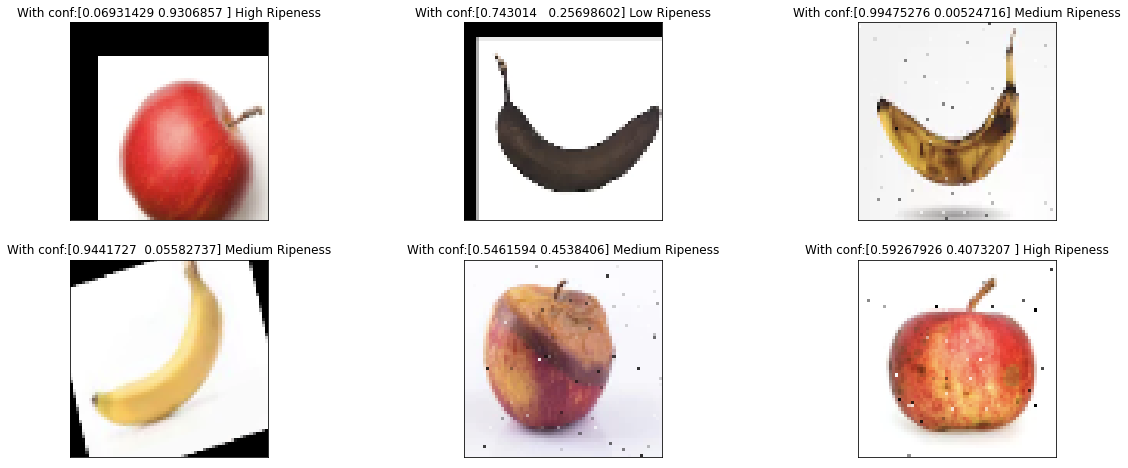

In [16]:
fig = plt.figure(figsize=(20, 8))
for i in range(len(vocab)):
    ax = fig.add_subplot(2,3, i + 1, xticks=[], yticks=[])
    ax.imshow(predict_run[i*2][0])
    ax.set_title("With conf:"+str(predict_run[i*2+1][0])+str(" ")+str(ripeness_check(ripe_check_hist[vocab[i]])))

#### This program correctly predicts the raw image 99% of the time and predicts the ripeness of the fruit on a 1:2 bases with a bias of 75:100. The bias comes from predictions of ripeness being within the same neighbour of the wanted output.

In [19]:
print("And that is all folks!")

And that is all folks!
